In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
energy_df = pd.read_excel(r'C:\Users\vd819\Divya\energy_dataset.xlsx')
weather_df = pd.read_excel(r"C:\Users\vd819\Divya\weather_features.xlsx")

# Merging the data 

In [4]:
# Check for columns full of zeros
zero_cols = energy_df.columns[(energy_df == 0).all()]

# Check for columns full of null values
null_cols = energy_df.columns[energy_df.isnull().all()]

# Combine both conditions
cols_to_drop = zero_cols.union(null_cols)

# Drop the columns
energy_df.drop(columns=cols_to_drop, inplace=True)

In [5]:
# Check for columns full of zeros
zero_cols = weather_df.columns[(weather_df == 0).all()]

# Check for columns full of null values
null_cols = weather_df.columns[weather_df.isnull().all()]

# Combine both conditions
cols_to_drop = zero_cols.union(null_cols)

# Drop the columns
weather_df.drop(columns=cols_to_drop, inplace=True)

In [6]:
energy_df['time'] = pd.to_datetime(energy_df['time'],utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'],utc=True)

In [7]:
wearther_df = weather_df.drop(columns=['city_name'])
###energy_df = energy_df.drop(columns=['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat', 'generation geothermal','generation hydro pumped storage aggregated','forecast wind offshore eday ahead','generation marine', 'generation wind offshore'])

In [8]:
weather_df.head()
weather_df.shape

(178396, 17)

In [9]:
energy_df.head()
energy_df.shape

(35064, 27)

In [11]:
weather_df = weather_df.groupby('dt_iso').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'snow_3h': 'mean',
    'clouds_all': 'mean',
    'weather_id': 'mean',
    'weather_main': lambda x: x.mode().iloc[0] if not x.empty else None,
    'weather_description': lambda x: x.mode().iloc[0] if not x.empty else None,
    'weather_icon': lambda x: x.mode().iloc[0] if not x.empty else None
}).reset_index()

In [12]:
print(weather_df.columns)

Index(['dt_iso', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed',
       'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')


In [13]:
weather_df.shape

(35064, 14)

In [16]:
merged_data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')
merged_data.head()
merged_data.shape

(35064, 41)

In [17]:
print(merged_data.columns)

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation_solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'dt_iso',
       'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h',
       'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description

# Exploriting analysis

In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

# Missing values imputation

In [19]:
null_counts = merged_data.isnull().sum()
print(null_counts)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil coal-derived gas             18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation fossil oil shale                    18
generation fossil peat                         18
generation geothermal                          18
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation marine                              19
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation_solar                               18
generation waste                               19
generation wind offshore                       18


In [20]:
merged_data = merged_data.ffill()#do isnull.sum then ffill

# outlier detection and replacement

In [21]:
def detect_and_replace_outliers(df):
    outlier_counts = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:  # Select only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detect outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outlier_counts[column] = len(outliers)
        
        # Replace outliers with median
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])
    
    return df, outlier_counts

merged_data_cleaned, outlier_counts = detect_and_replace_outliers(merged_data)

# Print the outlier counts for each column
print("Outlier counts for each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

# Optionally, print the cleaned DataFrame
print("\nCleaned DataFrame (first 10 rows):")
print(merged_data_cleaned.head(10))

Outlier counts for each column:
generation biomass: 87
generation fossil brown coal/lignite: 0
generation fossil coal-derived gas: 0
generation fossil gas: 2185
generation fossil hard coal: 0
generation fossil oil: 246
generation fossil oil shale: 0
generation fossil peat: 0
generation geothermal: 0
generation hydro pumped storage consumption: 3762
generation hydro run-of-river and poundage: 0
generation hydro water reservoir: 343
generation marine: 0
generation nuclear: 79
generation other: 1267
generation other renewable: 5
generation_solar: 0
generation waste: 328
generation wind offshore: 0
generation wind onshore: 377
forecast solar day ahead: 0
forecast wind onshore day ahead: 436
total load forecast: 0
total load actual: 0
price day ahead: 841
price actual: 699
temp: 0
temp_min: 0
temp_max: 0
humidity: 0
wind_speed: 830
rain_1h: 5088
rain_3h: 1617
snow_3h: 258
clouds_all: 496
weather_id: 2011

Cleaned DataFrame (first 10 rows):
                       time  generation biomass  \


# Feature engineering 

In [22]:
#coverting the datetime to hr months and days
merged_data['time'] = pd.to_datetime(merged_data['time'], format='%Y/%m/%d %H:%M:%S',errors='coerce')
#dividing the time to month day weekday weekend
merged_data['month'] = merged_data['time'].dt.month
merged_data['day'] = merged_data['time'].dt.day
merged_data['weekday'] = merged_data['time'].dt.day_name()
merged_data['weekend'] = merged_data['time'].dt.weekday >= 5
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,month,day,weekday,weekend
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,12,31,Wednesday,False
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False


In [23]:
#finding out unique values 
unique_values = merged_data[['weather_main', 'month', 'day','weekday','weekend']].apply(lambda x: x.unique())
print(unique_values)

weather_main    [clear, clouds, rain, fog, thunderstorm, drizz...
month                     [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
day             [31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
weekday         [Wednesday, Thursday, Friday, Saturday, Sunday...
weekend                                             [False, True]
dtype: object


# Peak - off peak hour with total load


In [24]:
print(merged_data['total load actual'])

0        25385.0
1        24382.0
2        22734.0
3        21286.0
4        20264.0
          ...   
35059    30653.0
35060    29735.0
35061    28071.0
35062    25801.0
35063    24455.0
Name: total load actual, Length: 35064, dtype: float64


In [25]:
merged_data['hour'] = merged_data['time'].dt.hour
# caluclate the average electricity demand for each hour for all days
hourly_avg_demand = merged_data.groupby('hour')['total load actual'].mean().reset_index()
hourly_avg_demand.columns = ['hour', 'avg_hourly_demand']
#merging the both datasets merged_data and hourly_avg_demand
merged_data = pd.merge(merged_data, hourly_avg_demand, on='hour', how='left')
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,weather_id,weather_main,weather_description,weather_icon,month,day,weekday,weekend,hour,avg_hourly_demand
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,800.0,clear,sky is clear,01n,12,31,Wednesday,False,23,25345.879535
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,800.0,clear,sky is clear,01n,1,1,Thursday,False,0,23951.776865
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,800.0,clear,sky is clear,01n,1,1,Thursday,False,1,23148.550308
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,800.0,clear,sky is clear,01n,1,1,Thursday,False,2,22785.642710
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,800.0,clear,sky is clear,01n,1,1,Thursday,False,3,22848.646133


In [26]:
# Create a column to classify hours as peak or off-peak based on the average hourly demand
def classify_peak_off_peak(row):
    if row['total load actual'] > row['avg_hourly_demand']:
        return 'peak'
    else:
        return 'off_peak'




In [27]:
merged_data['peak_hour'] = (merged_data['total load actual'] > merged_data['avg_hourly_demand']).astype(int)
merged_data['off_peak_hour'] = (merged_data['total load actual'] <= merged_data['avg_hourly_demand']).astype(int)


In [28]:
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,weather_description,weather_icon,month,day,weekday,weekend,hour,avg_hourly_demand,peak_hour,off_peak_hour
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,sky is clear,01n,12,31,Wednesday,False,23,25345.879535,1,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,sky is clear,01n,1,1,Thursday,False,0,23951.776865,1,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,sky is clear,01n,1,1,Thursday,False,1,23148.550308,0,1
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,sky is clear,01n,1,1,Thursday,False,2,22785.642710,0,1
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,sky is clear,01n,1,1,Thursday,False,3,22848.646133,0,1


In [38]:
merged_data.to_csv(r'C:\Users\vd819\Divya\merged_data.csv', index=False)

# Vizualization

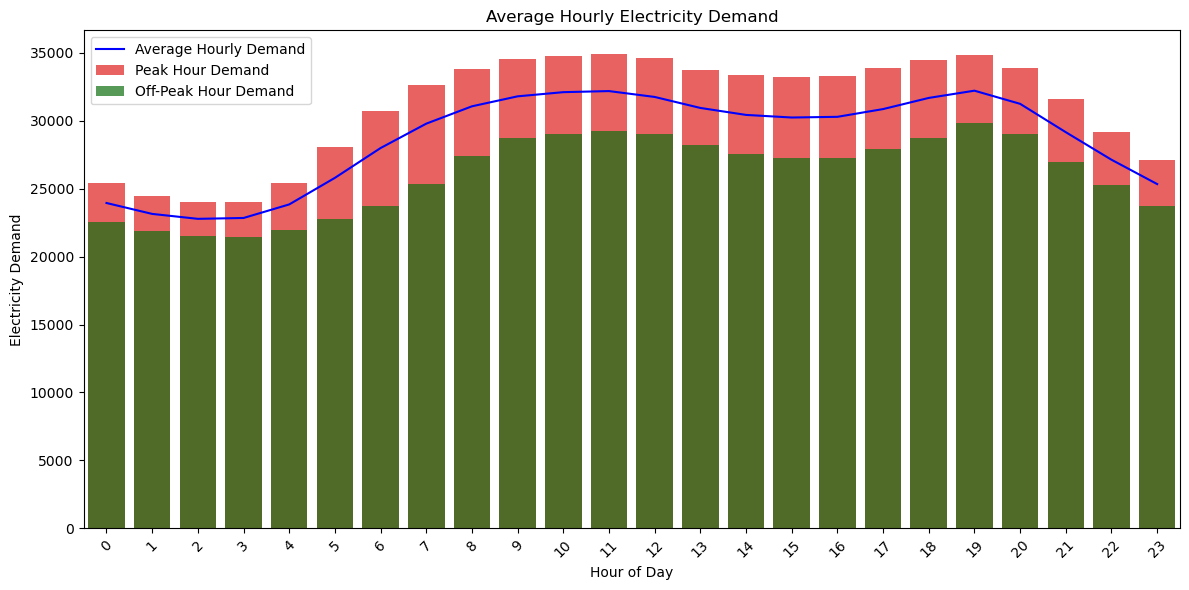

In [29]:
#PEAK AND OFF PEAK
# Calculate average hourly demand for peak and off-peak hours
hourly_avg_demand = merged_data.groupby('hour')['total load actual'].mean().reset_index()
avg_demand_peak = merged_data[merged_data['peak_hour'] == 1].groupby('hour')['total load actual'].mean().reset_index()
avg_demand_off_peak = merged_data[merged_data['peak_hour'] == 0].groupby('hour')['total load actual'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot average hourly demand
sns.lineplot(x='hour', y='total load actual', data=hourly_avg_demand, label='Average Hourly Demand', color='blue')

# Plot average hourly demand for peak and off-peak periods
sns.barplot(x='hour', y='total load actual', data=avg_demand_peak, color='red', alpha=0.7, label='Peak Hour Demand')
sns.barplot(x='hour', y='total load actual', data=avg_demand_off_peak, color='green', alpha=0.7, label='Off-Peak Hour Demand')

plt.title('Average Hourly Electricity Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Electricity Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#BOX PLOT OF PEAK AND OFF PEAK

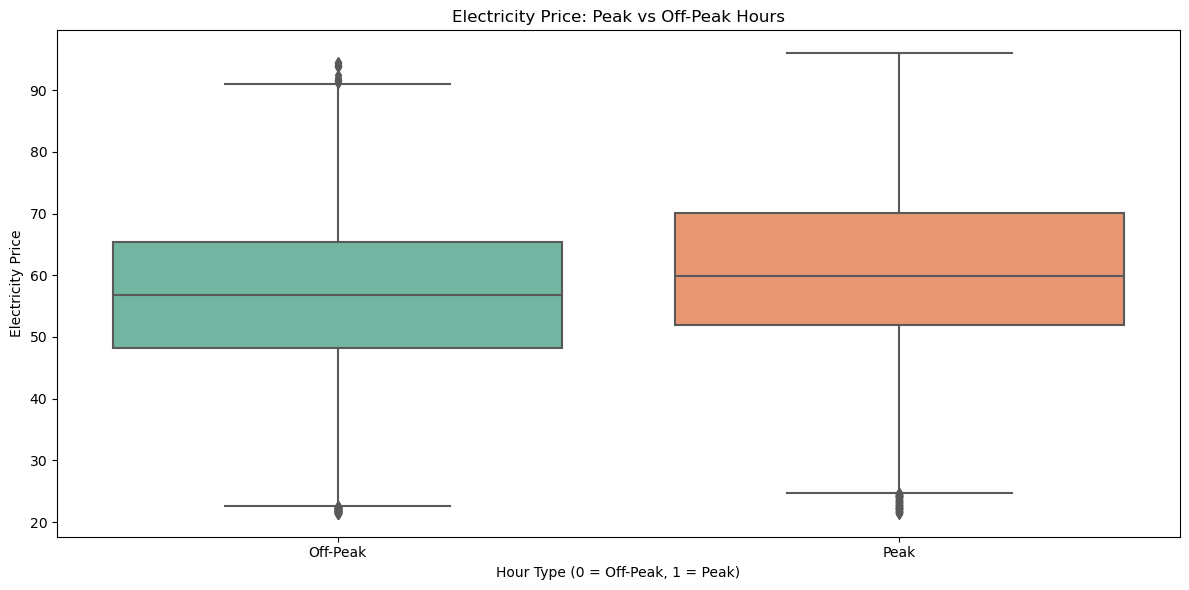

In [30]:
# Calculate average hourly price for peak and off-peak hours
avg_price_peak = merged_data[merged_data['peak_hour'] == 1].groupby('hour')['price actual'].mean().reset_index()
avg_price_off_peak = merged_data[merged_data['peak_hour'] == 0].groupby('hour')['price actual'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Box plot for price during peak and off-peak periods
sns.boxplot(x='peak_hour', y='price actual', data=merged_data, palette='Set2')
plt.title('Electricity Price: Peak vs Off-Peak Hours')
plt.xlabel('Hour Type (0 = Off-Peak, 1 = Peak)')
plt.ylabel('Electricity Price')
plt.xticks([0, 1], ['Off-Peak', 'Peak'])
plt.tight_layout()
######################################
plt.show()

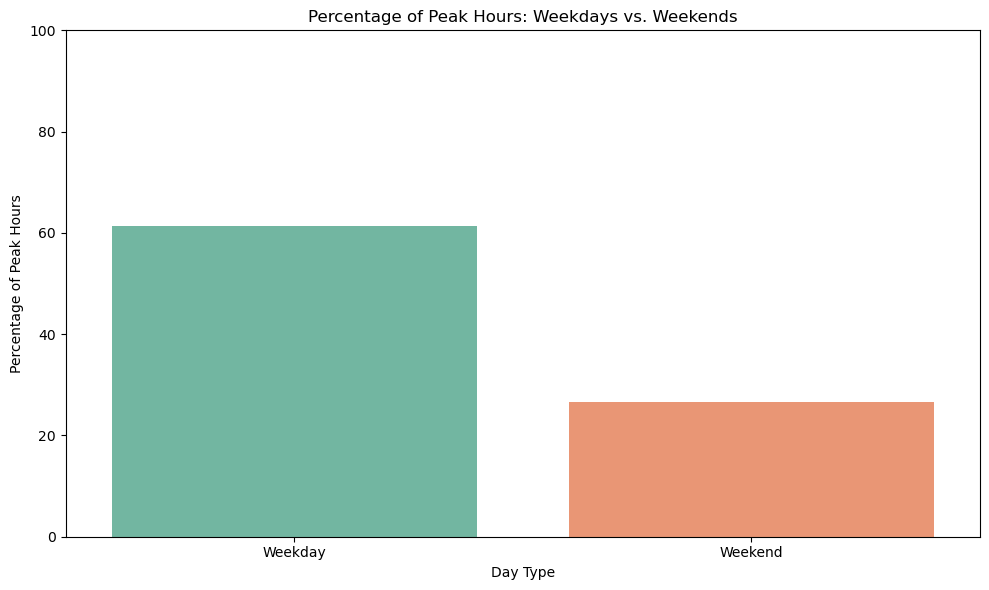

In [31]:
# Calculate percentage of peak hours for weekdays and weekends
weekday_peak_pct = merged_data[merged_data['weekend'] == False]['peak_hour'].mean() * 100
weekend_peak_pct = merged_data[merged_data['weekend'] == True]['peak_hour'].mean() * 100

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for weekday vs. weekend peak hours
sns.barplot(x=['Weekday', 'Weekend'], y=[weekday_peak_pct, weekend_peak_pct], palette='Set2')
plt.title('Percentage of Peak Hours: Weekdays vs. Weekends')
plt.xlabel('Day Type')
plt.ylabel('Percentage of Peak Hours')
plt.ylim(0, 100)  # Ensure y-axis starts from 0 to 100%
plt.tight_layout()

# Display the plot
plt.show()

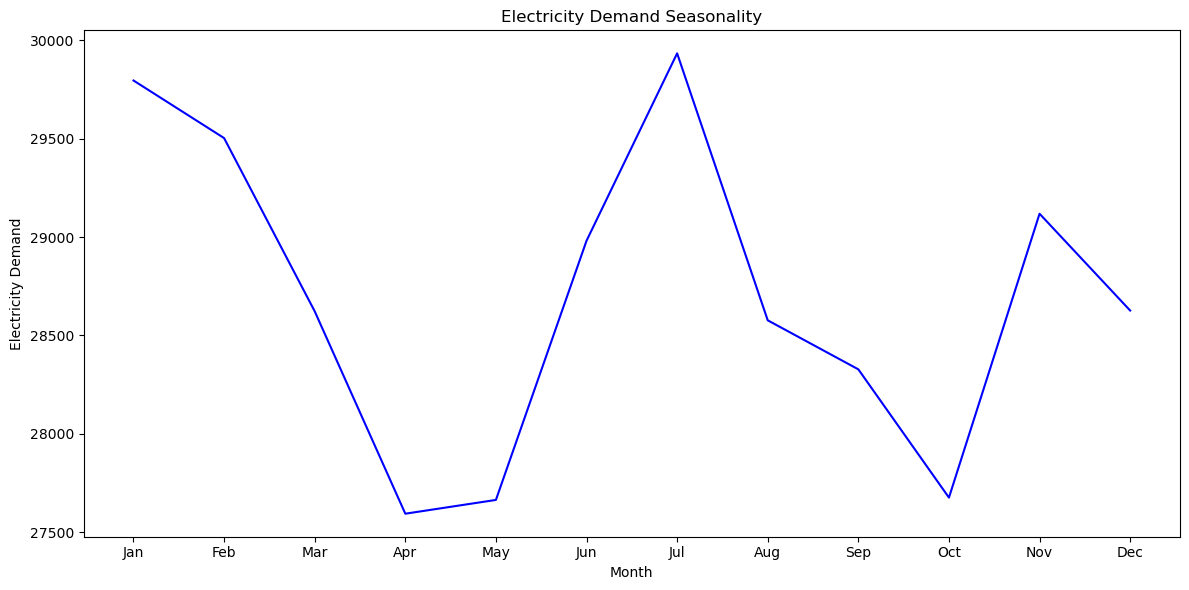

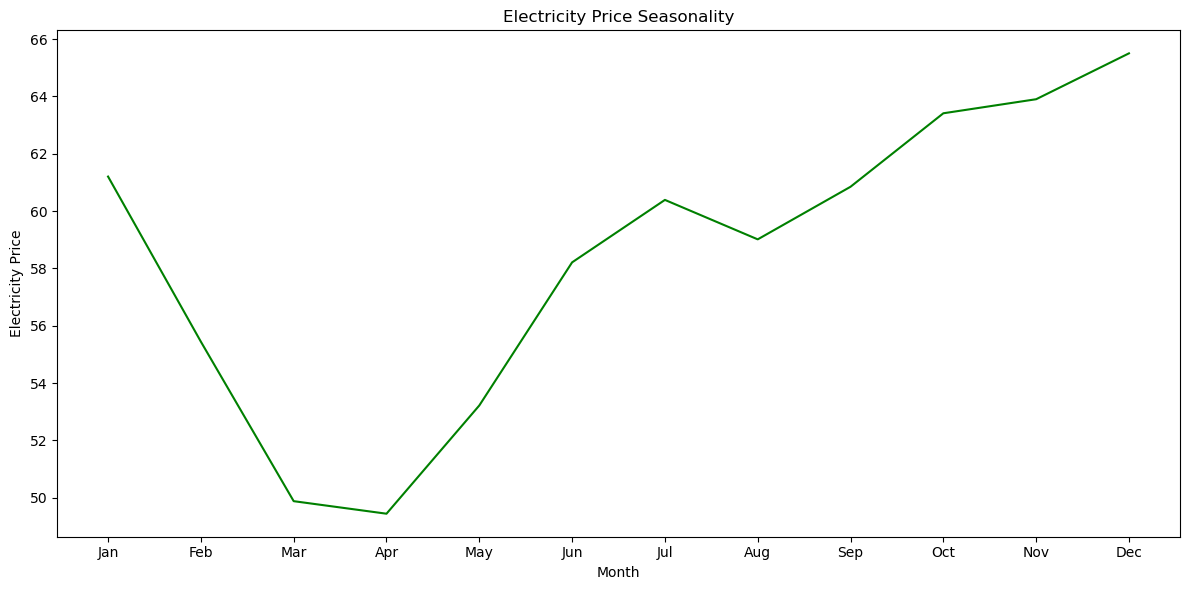

In [32]:
# Plotting demand over seasonality
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='total load actual', data=merged_data, ci=None, color='blue')
plt.title('Electricity Demand Seasonality')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

# Show plot
plt.show()

# Plotting price over seasonality
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='price actual', data=merged_data, ci=None, color='green')
plt.title('Electricity Price Seasonality')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

# Show plot
plt.show()

# Label encoding and corelation matrix

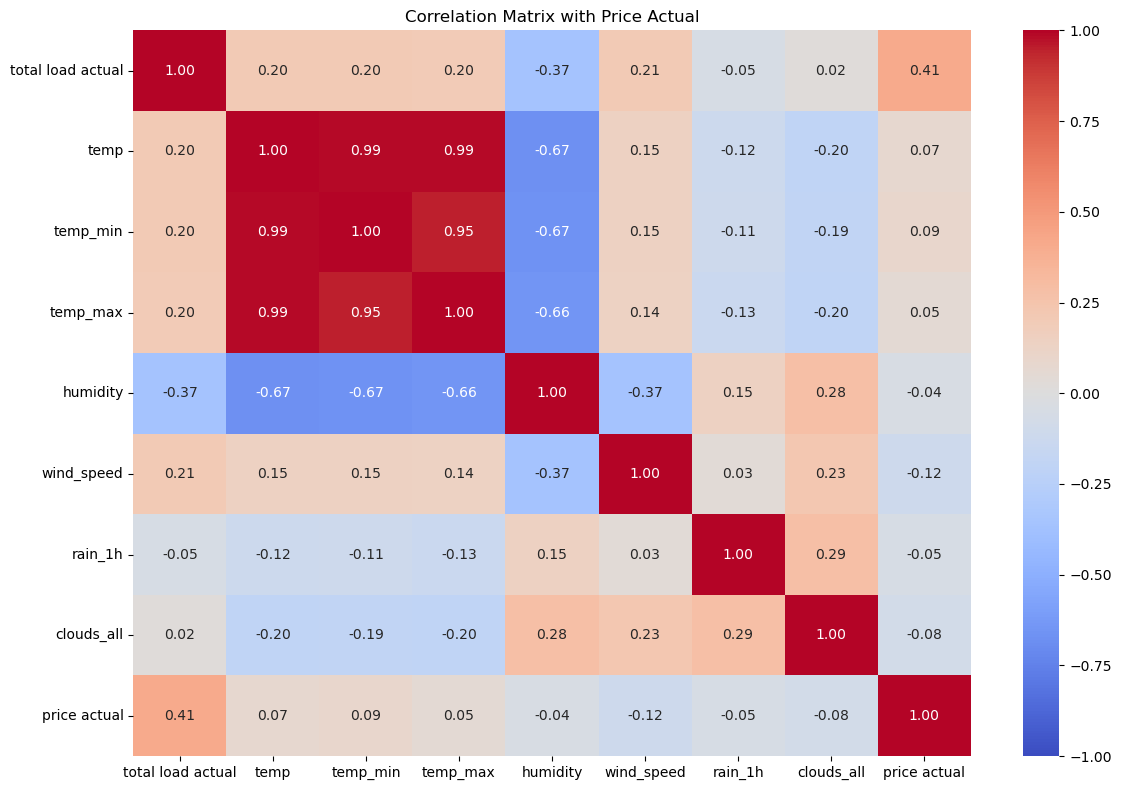

In [35]:
# Define the dependent variable (target)
dependent_variable = 'price actual'

# Define the independent variables (features)
independent_variables = [
    'total load actual', 'temp', 'temp_min', 'temp_max', 'humidity', 
    'wind_speed', 'rain_1h', 'clouds_all'
]

# Selecting the relevant columns
data_for_analysis = merged_data[independent_variables + [dependent_variable]]

# Calculate the correlation matrix
correlation_matrix = data_for_analysis.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Actual')
plt.tight_layout()

# Show plot
plt.show()

from above correlation matrix:
1.Strongest Correlations with 'Price Actual':
Total Load Actual (0.41): There is a moderate positive correlation between 'total load actual' and 'price actual'. This indicates that as electricity demand increases, prices tend to rise.
2. Moderate Negative Correlations with 'Price Actual':
Weekend (-0.19): There is a moderate negative correlation between 'weekend' and 'price actual', suggesting that electricity prices tend to be lower on weekends compared to weekdays.
3. Weak Correlations with 'Price Actual':
Temperature Variables (temp, temp_min, temp_max): The correlations between 'price actual' and temperature variables are weak (0.07 to 0.08). This suggests that temperature has a relatively small direct impact on electricity prices in this dataset.
Humidity (-0.04): The correlation between humidity and 'price actual' is very weak and negative.
Wind Speed (-0.12): Wind speed has a weak negative correlation with 'price actual'.
Rain_1h (-0.05): Rain in the last hour has a very weak negative correlation with 'price actual'.
Clouds All (-0.08): The overall cloudiness also has a weak negative correlation with 'price actual'.

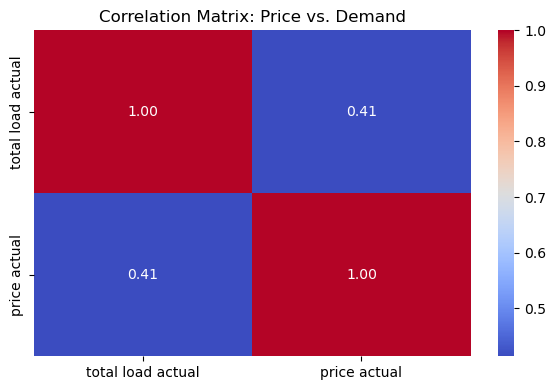

In [40]:
#correlation matrix for prime and demand
correlation_matrix = merged_data[['total load actual', 'price actual']].corr()

# Plotting correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Price vs. Demand')
plt.tight_layout()

# Show plot
plt.show()
# weather temp columns are important

# Vizualization for price

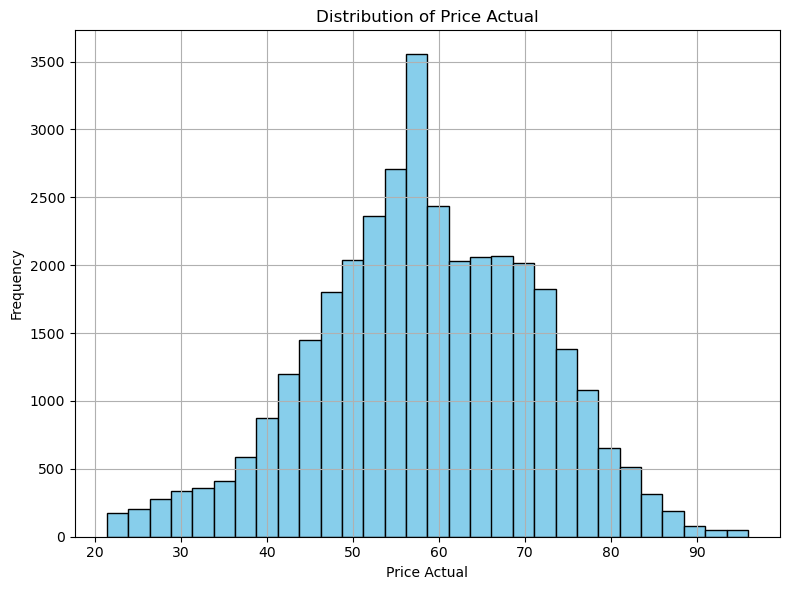

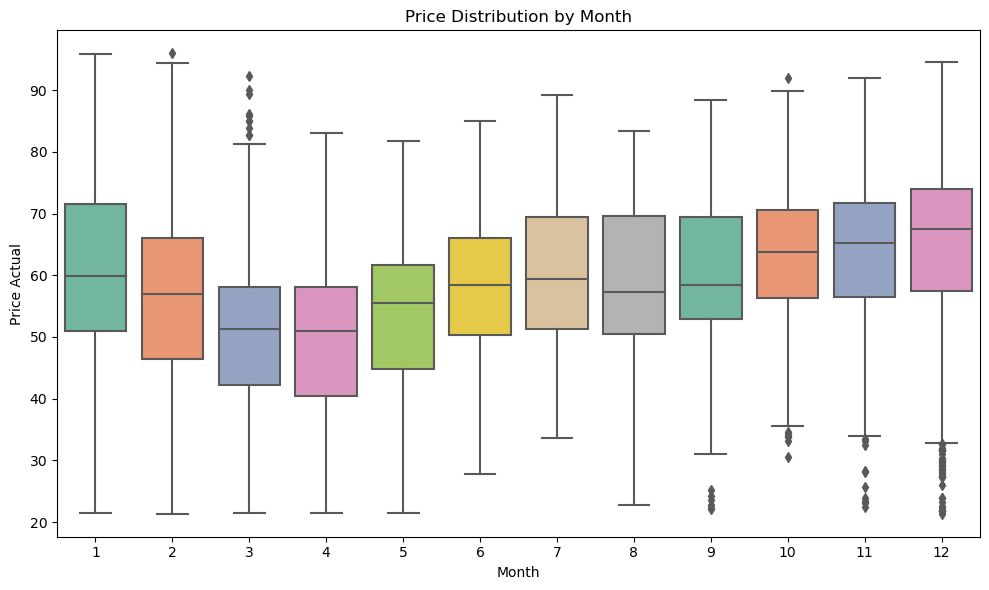

In [41]:
# Plotting histogram of price actual
plt.figure(figsize=(8, 6))
plt.hist(merged_data['price actual'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
# Show plot
plt.show()

# Box Plot for Price Distribution Across Different Categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price actual', data=merged_data, palette='Set2')
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price Actual')
plt.tight_layout()
plt.show()

#Scatter Plot of Price Actual vs. Total Load Actual
